# Word2Vec augmentations line

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My\ Drive/textaug/notebooks/Word2Vec

/content/drive/My Drive/textaug/notebooks/Word2Vec


In [0]:
import pandas as pd
import numpy as np
import re

Подгрузить данные

In [0]:
df_pos = pd.read_csv('../../data/twitts/positive.csv', sep=';', header=None).assign(positive=1)
df_neg = pd.read_csv('../../data/twitts/negative.csv', sep=';', header=None).assign(positive=0)

Объединить

In [0]:
tweets = df_pos[[3,'positive']].append( df_neg[[3,'positive']], ignore_index=True ).rename({3:'tweet'}, axis=1)

In [0]:
tweets.head(15)

,tweet,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
5,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1
6,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1
7,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1
8,Поприветствуем моего нового читателя @Alexey17...,1
9,Теперь у меня есть частичка Сиднея :) #Sydney ...,1


In [0]:
tweets = tweets.drop_duplicates() #важно, потому что дубликаты кажется есть

In [0]:
tweets.positive.value_counts()

1    110396
0    107044
Name: positive, dtype: int64

Убрать из данных характерные для твиттера вещи (RT, @ и т.д.)

In [0]:
tweets.tweet = tweets['tweet'].apply(lambda x: re.sub('[\Wa-zA-Z_\d]+', ' ', x) )
tweets.tweet = tweets['tweet'].apply(lambda x: x.lower().strip() )

Немного пристальнее посмотреть на записи

In [0]:
for i, v in zip(range(1,100), tweets['tweet'][50:60]):
    print(i, v)

1 а стояк теперь снова стояк вселенная вернула все на свои места
2 прифетигг солныско каг тфаи дила мну сичас фф больниську идеть к логопеду
3 да нашла фоточку в иг и нагло спиздила ничего с фотографиями меня уже статусы в вконтакте бывают
4 а у нас в нижнем слякотная погода брр но у нас офигенный привоз заходим заходим
5 короче видимо ни в какой архитектурный я не иду там капец конечно
6 ну в сделаешь тогда я дарья а ты
7 плак плак надеюсь на драфте тогда их вытяну
8 а моя кроме поорать еще просится на балкон хвост поморозить минуту посидит и назад просится
9 каждому так болеть когда к тебе друзья в гости ходят
10 мам мне так хреново выпей таблетку и на работу на следующей недели пойдем в сауну мама умеет поддержать и добавить стимула


Прелестно.
Пора переводить данные, но сначала разделю на train и test части, чтоб аугментировать только train

In [0]:
X = tweets.tweet
y = tweets.positive

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [0]:
X_train.shape

(163080,)

### W2V augmentation part

In [0]:
!pip install --upgrade gensim
!pip install annoy

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 645kB 8.8MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=301865 sha256=24bbc8830eb2e0395f75d4f2ced9db1443a80da5985728f653339e8ddec17880
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [0]:
from gensim.test.utils import datapath
from gensim import utils
import gensim.models

Скачать файл с векторами [отсюда](http://panchenko.me/data/dsl-backup/w2v-ru/all.norm-sz100-w10-cb0-it1-min100.w2v)

Я использую самый лёгкий файл, но в перспективе можно и более тяжёлые, всё лежит [здесь](https://nlpub.mipt.ru/Russian_Distributional_Thesaurus)

In [0]:
!wget -O mipt_vecs.w2v http://panchenko.me/data/dsl-backup/w2v-ru/all.norm-sz100-w10-cb0-it1-min100.w2v

--2020-01-30 02:10:19--  http://panchenko.me/data/dsl-backup/w2v-ru/all.norm-sz100-w10-cb0-it1-min100.w2v
Resolving panchenko.me (panchenko.me)... 130.104.253.4
Connecting to panchenko.me (panchenko.me)|130.104.253.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519958459 (496M)
Saving to: ‘mipt_vecs.w2v’

mipt_vecs.w2v       100%[===================>] 495.87M   486KB/s    in 17m 38s 

2020-01-30 02:27:58 (480 KB/s) - ‘mipt_vecs.w2v’ saved [519958459/519958459]



In [0]:
mipt_model = gensim.models.KeyedVectors.load_word2vec_format('mipt_vecs.w2v', binary=True, unicode_errors='ignore')

Напишу тупенькую функцию, чтоб аугментировать предложения, но сначала ещё кое-что

In [0]:
X_w2v = X_train.copy()

In [0]:
model = mipt_model

In [0]:
from gensim.similarities.index import AnnoyIndexer #вопрос, может ли работать
annoy_index = AnnoyIndexer(mipt_model, num_trees=20)

/usr/local/lib/python3.6/dist-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


Стандартный поиск наиболее похожего слова слишком долгий, поэтому буду пользоваться [`AnnoyIndexer`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html)

Неисследованная опция `num_trees` кажется улучшает качество поиска похожего слова; если компьютер мощный, то можно попробовать поднять значение до `100-500`

In [0]:
%timeit model.most_similar('слово', topn=2, indexer=annoy_index)
%timeit model.most_similar('слово', topn=1)

The slowest run took 22.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 62.8 µs per loop
10 loops, best of 3: 76.9 ms per loop


In [0]:
print( 'Annoy:', model.most_similar('слово', topn=2, indexer=annoy_index) )
print( 'Standard:', model.most_similar('слово', topn=2) )

Annoy: [('слово', 1.0), ('произнесено', 0.6672298312187195)]
Standard: [('слово…', 0.8392893075942993), ('словечко', 0.7949840426445007)]


In [0]:
import random
def sen_aug_one_change(sen):
    words = sen.split(' ')
    indexes = list( range(len(words)) )
    random.shuffle(indexes)
    for i in indexes:
        if words[i] in model:
            words[i] = model.most_similar(words[i], topn=1)[0][0]
            return ' '.join(words)
    return sen  # no replacement was possible

In [0]:
import random
def sen_aug_one_change_annoy(sen):
    words = sen.split(' ')
    indexes = list( range(len(words)) )
    random.shuffle(indexes)
    for i in indexes:
        if words[i] in model:
            words[i] = model.most_similar(words[i], topn=2, indexer=annoy_index)[1][0]
            return ' '.join(words)
    return sen  # no replacement was possible

In [0]:
import random
def sen_aug_all_changes(sen):
    words = sen.split(' ')
    for i in range(len(words)):
        if words[i] in model:
            words[i] = model.most_similar(words[i], topn=3)[1][0]
    return ' '.join(words)

In [0]:
import random
def sen_aug_all_changes_annoy(sen):
    words = sen.split(' ')
    for i in range(len(words)):
        if words[i] in model:
            words[i] = model.most_similar(words[i], topn=3, indexer=annoy_index)[1][0]
    return ' '.join(words)

Пример полностью переделанных твитов, но для быстроты будем менять по одному слову

In [0]:
i = random.randint(0, len(tweets))
print('Original tweet:', tweets.tweet[i])
print('All change words:', sen_aug_all_changes(tweets.tweet[i]) )
print('All change words (with annoy):', sen_aug_all_changes_annoy(tweets.tweet[i]) )

Original tweet: и не говори что не так
All change words: как так молчи не так же
All change words (with annoy): …меж только скажи ли только тоже


Сравниваю функции по скорости работы

In [0]:
%timeit sen_aug_all_changes(X_w2v[0])
%timeit sen_aug_all_changes_annoy(X_w2v[0])
%timeit sen_aug_one_change(X_w2v[0])
%timeit sen_aug_one_change_annoy(X_w2v[0])

1 loop, best of 3: 1.32 s per loop
1000 loops, best of 3: 1.41 ms per loop
10 loops, best of 3: 76.5 ms per loop
The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 146 µs per loop


С учётом количества данных в `X_w2v` = 163080, предпочитаю скорость качеству

In [0]:
%time X_add = X_w2v.apply(lambda x: sen_aug_one_change_annoy(x))

CPU times: user 21 s, sys: 84.1 ms, total: 21 s
Wall time: 21.1 s


Примеры того, какие аугментации получились

In [0]:
n_tweets = 15
ind = random.randint(n_tweets, len(X_w2v))
for w2v,add in zip(X_w2v.values[ind-15:ind], X_add.values[ind-n_tweets:ind]):
    print('Origin:', w2v)
    print('Aug:', add )
    print('__________')

Origin: у меня по географии одна а по обществу с историей обж физре ни одной
Aug: у меня по географии одна а по обществу с рассказанной обж физре ни одной
__________
Origin: хахах а чего тебя протянуло то на такую тему ты же трезв или
Aug: хахах а чего ты протянуло то на такую тему ты же трезв или
__________
Origin: и лифт не работает и зарядки мало на телефоне
Aug: и лифт не работает и зарядки только на телефоне
__________
Origin: была дочкой стала сыном
Aug: была дочкой прекратила сыном
__________
Origin: хорошо поиграли в мафию за одну ночь меня убили вылечили застрелили и маньяк оказался микрофилом
Aug: хорошо поиграли в мафию за одну ночь меня убили вылечили застрелили прославившими маньяк оказался микрофилом
__________
Origin: хиатус древних вернется на экраны уже в году января
Aug: хиатус древних вернется на экранов уже в году января
__________
Origin: как страшно вдруг это у нас психика сломана есть те кто ничего в этом плохого не видит
Aug: как страшно вдруг это у нас психика 

In [0]:
X_train = X_w2v.append( X_add, ignore_index=True)

In [0]:
y_train = y_train.append(y_train, ignore_index=True)

In [0]:
print( X_train.shape[0], y_train.shape[0] )

326160 326160


Снова нужно вычистить дупликаты, сделаю это немного странно, т.к. нужно деражать правильные ответы

In [0]:
df_train = pd.DataFrame({'tweet': X_train.apply(lambda x: re.sub('(\W+|\d+|[A-Za-z]+|_+)', ' ', x) ), 
                         'positive': y_train})

In [0]:
df_train

,tweet,positive
0,съехал с рельс и теперь заправляется кофе,0
1,так ведь никто не заставляет вляпываться то те...,0
2,к любви отношусь со смехом,1
3,интересно а мой брат в лет будет приезжать ко ...,1
4,бля мне этот сон не дает покоя он был таким ре...,0
...,...,...
326155,сибирь барнаул середина декабря близится а сне...,0
326156,кей я на электронную почту тебе лучше скину ка...,1
326157,гиляз ты же говорила что аа забила на это вот ...,0
326158,нге года интенс любимая в пролёте,0


In [0]:
df_train = df_train.drop_duplicates()

In [0]:
len(df_train)

317690

In [0]:
X_train, y_train = df_train.tweet, df_train.positive

На всякий случай можно ещё раз почистить, ещё раз убрать все знаки препинания и цифры

Но для начала нужно слить train и test, чтоб vectorize все строки, поэтому запоминаю `split_index`

In [0]:
split_index = X_train.shape[0]
X = X_train.append(X_test).apply(lambda x: re.sub('(\W+|\d+|[A-Za-z]+|_+)', ' ', x) )

In [0]:
X[split_index-10:split_index]

326150             бедняга латифа издвается над ним наверно
326151    нет тортиков есть мамины рафаэлки и армяне леп...
326152    ты про случай в туалете ну мы просто случайно ...
326153                            анна не придёт бедапечаль
326154    написать что ли пост о войне с хаскеля прежнем...
326155    сибирь барнаул середина декабря близится а сне...
326156    кей я на электронную почту тебе лучше скину ка...
326157    гиляз ты же говорила что аа забила на это вот ...
326158                    нге года интенс любимая в пролёте
326159    я не знаю что со мной но мне так охото побегат...
Name: tweet, dtype: object

In [0]:
assert len(X_test) + len(X_train) == len(X)

In [0]:
len(X)

372050

Почищено, теперь векторизую

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

Снова разделяю по split индексу

In [0]:
X_vect_train, X_vect_test = X_vect[:split_index,], X_vect[split_index:,]

In [0]:
print('Размеры верны:', X_vect_train.shape[0] == y_train.shape[0] )
print('Размеры верны:', X_vect_test.shape[0] == y_test.shape[0] )

Размеры верны: True
Размеры верны: True


In [0]:
vectorizer.get_feature_names()[800:820]

['автомобилем',
 'автомобили',
 'автомобилист',
 'автомобилистам',
 'автомобилистов',
 'автомобилисты',
 'автомобиль',
 'автомобильной',
 'автомобильном',
 'автомобильные',
 'автомобильный',
 'автомобильчик',
 'автомобильчиках',
 'автомобиля',
 'автомобилях',
 'автомойка',
 'автоновости',
 'автономия',
 'автономная',
 'автономном']

### Go учиться

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [0]:
clf = LogisticRegression(max_iter=400)

In [0]:
clf.fit(X_vect_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = clf.predict(X_vect_test)

In [0]:
y_pred.shape

(54360,)

In [0]:
accuracy_score(y_pred, y_test)

0.7332781456953642

In [0]:
f1_score(y_pred, y_test)

0.7440735706846945

ок, хорошо

теперь можно менять параметры

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
gs = RandomizedSearchCV(clf, {'C': [0.8, 0.9, 1., 1.1, 1.2, 1.25, 1.35, 1.4]}, cv=2, verbose=1)

In [0]:
gs.fit(X_vect_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  2.8min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=400,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.8, 0.9, 1.0, 1.1, 1.2, 1.25,
                                              1.35, 1.4]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [0]:
gs.best_params_

{'C': 1.4}

In [0]:
y_pred = gs.best_estimator_.predict(X_vect_test)

In [0]:
accuracy_score(y_pred, y_test)

0.7331861662987491

In [0]:
f1_score(y_pred, y_test)

0.7430373467507618

### Bootstrap

In [0]:
len(y_pred), len(y_test)

(54360, 54360)

In [0]:
answers = (y_pred == y_test.values)

In [0]:
means = np.array([np.mean( answers[ np.random.randint(len(answers), size=len(answers)) ] ) for _ in range(1000)])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

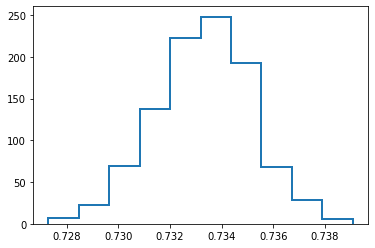

In [0]:
plt.hist(means, histtype='step', lw=2);

In [0]:
print(f'Mean: {means.mean():.3f} +/- {means.std()*2:.3f} (95% conf.)')

Mean: 0.733 +/- 0.004 (95% conf.)
